In [2]:
import pandas as pd
import numpy as np
import re
import math
import requests
from bs4 import BeautifulSoup

In [40]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import porter
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import psycopg2 as pc
from IPython import display


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielstephensen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielstephensen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Before going further and executing the code, make sure to change the database name, username and password for your SQL database and the path to the path to the 'SQLtables' repository with the csv files in it, so it adjusted to your computer.

In [5]:
SQL_database_login = "dbname=postgres user=postgres password=***"
SQLtables_path = "/Users/danielstephensen/Desktop/DataScienceGit/SQLtables/"

## Function Definitions

In [10]:
#cleantext cleans the input string with the following functions: Characters are set to lowercase, 
#urls are substituted with <URL>, dates are substitured with <DATE>, emails are substitured with <EMAIL>
#numbers are substitured with <NUM>, newlines and non-letter characters are removed.
def cleantext(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'<|>', "", text)
    text = re.sub(r'(https?:\/\/)?w{0,3}\.?[a-z]+\.[a-z]\w*[\w\/-]*', "<URL>", text)
    text = re.sub(r'(jan\.?(uary)?|feb\.?(uary)?|mar\.?(ch)?|apr\.?(il)?|may|jun\.(e)?|jul\.(y)?|aug\.?(ust)?|sep\.?(tember)?|oct\.?(ober)?|nov\.?(ember)?|dec\.?(ember)?|monday|tuesday|wednesday|thursday|friday|saturday|sunday) (the )?\d{1,2}((th)?,?( \d{4})?)?', "<DATE>", text)
    text = re.sub(r'\w+@\w+\.[a-zA-Z]{2,3}', "<EMAIL>", text)
    text = re.sub(r'[0-9]+', "<NUM>", text)
    text = re.sub(r'(\\n)+|\s{2,}|(\\t+)', " ", text)
    text = re.sub(r'\.|,|\\|-|\?|\(|\)|\||&|"|”|“|:|!|\+|-|–|—|\/|\$|%|€|#|;|\[|\]|©|®|…|=', "", text)
    return text

#cleanMetaKeywords cleans the input string with the following functions: 
#Characters are set to lowercase, newlines and non-letter characters are removed.
def cleanMetaKeywords(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'(\\n)+|\s{2,}|(\\t+)', " ", text)
    text = re.sub(r'\.|\\|-|\?|\(|\)|\||&|"|”|“|:|!|\+|-|\'|–|—|\/|\$|%|€|#|;|\[|\]|©|®|…|=|<|>', "", text)
    return text

def tokenize(text):
    return word_tokenize(text)

def stopword(word_list):
    stop_words = stopwords.words('english')
    
    return [word for word in word_list if word not in stop_words]

def stemming(word_list):
    stemmer = porter.PorterStemmer()

    return [stemmer.stem(word) for word in word_list]


## Task 1

In [7]:
#Reading the data from 1mio-raw.csv
dataTotal = pd.read_csv('1mio-raw.csv/1mio-raw.csv')

#We will only analyse a smaller part of the data set
data = dataTotal[:1000]


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
#Cleaning the content
cleaned_content = [cleantext(article_content) for article_content in data['content']]

#Tokenizing the cleaned data
tokens = [tokenize(clean_text) for clean_text in cleaned_content]

#Removing stopwords
stopwords = [stopword(token_list) for token_list in tokens]

#Stemming the data (this is used for the 'keywords' attribute)
stemmed_data = [stemming(stopword_list) for stopword_list in stopwords]

#Cleaning meta keywords
clean_meta_keywords = [cleanMetaKeywords(metakeyword) for metakeyword in data["meta_keywords"]]


In [12]:
#Making sure that each element of 'tags', 'authors' and 'meta_keywords' are stripped stings and converting them to arrays
data["tags"] = [[tag.strip for tag in (str(i)).split(",")] for i in data["tags"]]
data["authors"] = [[author.strip for author in (str(i)).split(",")] for i in data["authors"]]
data["meta_keywords"] = [[meta_keyword.strip for meta_keyword in (str(i)).split(",")] for i in clean_meta_keywords]
data["keywords"] = stemmed_data
data["content"] = cleaned_content


<ipython-input-12-949903fe36fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["tags"] = [[tag.strip for tag in (str(i)).split(",")] for i in data["tags"]]
<ipython-input-12-949903fe36fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["authors"] = [[author.strip for author in (str(i)).split(",")] for i in data["authors"]]
<ipython-input-12-949903fe36fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [13]:
#Relation tables
article_tags = data[['id','tags']].explode('tags')
owns = data[['id', 'domain']]
article_authors = data[['id','authors']].explode('authors')
article_keywords = data[['id','keywords']].explode('keywords')
article_meta_keywords  = data[['id','meta_keywords']].explode('meta_keywords')
article_types = data[['id','type']]


In [23]:
#Entity tables
articles = data[['id','content','url','scraped_at','inserted_at','updated_at','meta_description','title']]
keywords = pd.DataFrame(set(data[['keywords']].explode('keywords')))
meta_keywords = pd.DataFrame(set(data[['meta_keywords']].explode('meta_keywords')))
tags = pd.DataFrame(set(data[['tags']].explode('tags')))
domains = pd.DataFrame(set(data['domain']))
authors = pd.DataFrame(set(data[['authors']].explode('authors')))
types =  pd.DataFrame(set(data['type']))

In [19]:
#Entities to CSV
articles.to_csv("SQLtables/articles.csv",index=False,header=False)
keywords.to_csv("SQLtables/keywords.csv",index=False,header=False)
meta_keywords.to_csv("SQLtables/meta_keywords.csv",index=False,header=False)
tags.to_csv("SQLtables/tags.csv",index=False,header=False)
authors.to_csv("SQLtables/authors.csv",index=False,header=False)
domains.to_csv("SQLtables/domains.csv",index=False,header=False)
types.to_csv("SQLtables/types.csv",index=False,header=False)

#Relations to CSV
owns.to_csv("SQLtables/owns.csv",index=False,header=False)
article_authors.to_csv("SQLtables/article_authors.csv",index=False,header=False)
article_tags.to_csv("SQLtables/article_tags.csv",index=False,header=False)
article_keywords.to_csv("SQLtables/article_keywords.csv",index=False,header=False)
article_meta_keywords.to_csv("SQLtables/article_meta_keywords.csv",index=False,header=False)
article_types.to_csv("SQLtables/article_types.csv",index=False,header=False)

In [20]:
#Setting up a connection with the SQL server. Make sure that you write your own dbname, user and password as input
conn = pc.connect(SQL_database_login)
cur = conn.cursor()

In [41]:
#Creating tables if they are not on the SQL server already
cur.execute("BEGIN TRANSACTION;")
cur.execute("CREATE TABLE IF NOT EXISTS public.article(id integer, content text COLLATE pg_catalog.\"default\", url text COLLATE pg_catalog.\"default\", scraped_at date, inserted_at date, updated_at date, meta_description text COLLATE pg_catalog.\"default\", title text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.article_keyword(article_id integer, keyword text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.article_meta_keywords(article_id integer, meta_keyword text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.article_tags(article_id integer,tag text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.authors(name text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.authors_of(article_id integer, author_name text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.domain(name text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.keywords(keyword text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.meta_keywords(meta_keyword text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.owns(article_id integer, domain_name text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.tags(tag text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.types(type text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.article_types(article_id integer,type text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("COMMIT TRANSACTION;")

InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


In [22]:
#Setting up the SQL tables from the csv files created above 
#(first all current tuples in the tables are deleted and then the new data is copied into the tables)
cur.execute("BEGIN TRANSACTION;")
cur.execute("delete from article *; copy article from '" + SQLtables_path + "articles.csv' with (format csv);")
cur.execute("delete from authors *; copy authors from '" + SQLtables_path + "authors.csv' with (format csv);")
cur.execute("delete from authors_of *; copy authors_of from '" + SQLtables_path + "article_authors.csv' with (format csv);")
cur.execute("delete from owns *; copy owns from '" + SQLtables_path + "owns.csv' with (format csv);")
cur.execute("delete from tags *; copy tags from '" + SQLtables_path + "tags.csv' with (format csv);")
cur.execute("delete from keywords *; copy keywords from '" + SQLtables_path + "keywords.csv' with (format csv);")
cur.execute("delete from meta_keywords *; copy meta_keywords from '" + SQLtables_path + "meta_keywords.csv' with (format csv);")
cur.execute("delete from domain *; copy domain from '" + SQLtables_path + "domains.csv' with (format csv);")
cur.execute("delete from article_tags *; copy article_tags from '" + SQLtables_path + "article_tags.csv' with (format csv);")
cur.execute("delete from article_keyword *; copy article_keyword from '" + SQLtables_path + "article_keywords.csv' with (format csv);")
cur.execute("delete from article_meta_keywords *; copy article_meta_keywords from '" + SQLtables_path + "article_meta_keywords.csv' with (format csv);")
cur.execute("delete from types *; copy types from '" + SQLtables_path + "types.csv' with (format csv);")
cur.execute("delete from article_types *; copy article_types from '" + SQLtables_path + "article_types.csv' with (format csv);")
cur.execute("COMMIT TRANSACTION;")
cur.fetchall()

InsufficientPrivilege: could not open file "/Users/danielstephensen/Desktop/DataScienceGit/SQLtables/articles_table.csv" for reading: Permission denied
HINT:  COPY FROM instructs the PostgreSQL server process to read a file. You may want a client-side facility such as psql's \copy.


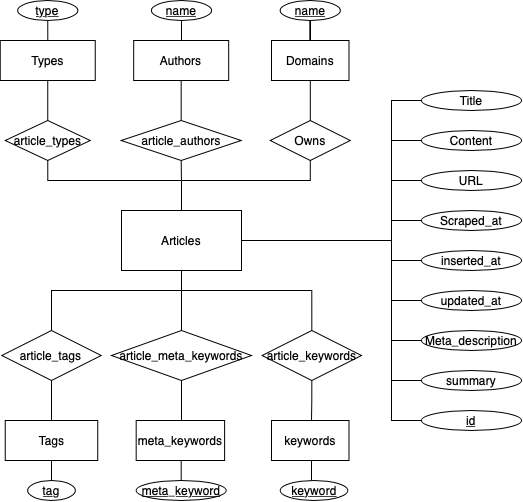

In [39]:
display.Image("diagram.png")

Choice of Schema
We have designed our database around the articles, using article_ID as the main primary key, which other relations refeer to.

the table 'article' has the attributes which uniquely belonging to the given article. Attributes such as information about the time it was scraped, the URL, the type etc. all uniquely belongs to an article.

We chose to create functional dependencies for the attributes 'tags', 'meta_keywords' and 'keywords' since each were consisting of up to a list of elements, making it hard to explore in SQL.

Thus the relation tags consist of an unique row for each tag of each article. The same is true for meta_keywords and keywords.

The relation Domain is one-to-many relation, since each article has one domain, but one domain can have many articles. Thus it makes sence to make a relation for domain.

The relation Authors is a many-to-many relationship since each author can write many articles and any article can have multiple authors.

Each relation thus binds our tables 'Authors', 'Domain', 'Tags', 'Meta_keywords' and 'keywords'. The tables right now only consist of a distinct list of author name, domain name, tag, meta_keyword and keyword. But this design enables easy scaling, if we want to add more information each table. For example the age of each author would easily be added to the 'authors' table.


## Task 2

### 2.1: Atrributes for each relation

article: id, title, content, url, scraped_at, inserted_at, updated_at, meta_desciption, summary

article_tags: tag, article_id

article_meta_keywords: meta_keyword, article_id

article_keywords: keyword, article_id

article_authors: author, article_id

article_types: type, article_id

own: name, article_id

tags: tag

meta_keywords: meta_keyword

keywords: keyword

authors: name

types: type

domains: name

### 2.2: Functional dependencies for each relation

The only relation with a functional dependecy is 'article', which has the following function dependency:

id -> title, content, url, scraped_at, inserted_at, updated_at, meta_desciption, summary

### 2.3 Primary keys for each relation

Only article, tags, meta_keywords, keywords, authors, types, domains has primary keys, which are shown below:

article: id

tags: tag

meta_keywords: meta_keyword

keywords: keyword

authors: name

types: type

domains: name

All relations are in BCNF.

Advantages of using BCNF:



Disadvantages of using BCNF:



In [42]:
#Milestone 2 Task 3
#1 [sql] List the domains of news articles of reliable type and scraped at or after January 15, 2018. NOTE: Do not include duplicate domains in your answer.
cur.execute("select distinct domain_name from owns where article_id in (select id from article a where type = 'reliable' and a.scraped_at > '2018-01-24')")
print(cur.fetchall())
#2 [sql] List the name(s) of the most prolific author(s) of news articles of fake type. An author is among the most prolific if it has authored as many or more fake news articles as any other author in the dataset.
#We chose to fetch top 5 authors with most fake news articles. 
cur.execute("select author_name, count(*) from authors_of where article_id in (select id from article where type = 'fake') and author_name != 'nan' group by author_name order by count(*) desc limit 5 ")
print(cur.fetchall())

#3. [sql] Count the pairs of article IDs that exhibit the exact same set of meta-keywords, but only return the pairs where the set of meta-keywords is not empty. 
#cur.execute("select aa.id, bb.id from (select  from article_meta_keywords where meta_keyword !='') aa inner join (select   from article_meta_keywords where meta_keyword !='') bb on aa.meta_keyword = bb.meta_keyword  where aa.id < bb.id order by aa.id")
print(cur.fetchall())

#cur.execute(" select  aa.id, bb.id from (select count(meta_keyword) , id from article_meta_keywords where meta_keyword !=''group by id order by count desc) aa inner join  (select count(meta_keyword) , id from  article_meta_keywords  where meta_keyword !=''group by id order by count desc) bb on aa.count = bb.count  where aa.id < bb.id  order by aa.id  ")
print(cur.fetchall())



InFailedSqlTransaction: current transaction is aborted, commands ignored until end of transaction block


#1 relational algebra

reliable_domains := π{domain_name} (σ{a.type = 'reliable' and a.scraped_at > '2018-01-24' and a.id = o.article_id}(owns X article ))

reliable_domains := π{domain_name} owns ⋈{a.type = 'reliable' and a.scraped_at > '2018-01-24' and a.id = o.article_id} article

2# extended relational algebra

reliable_authors := π{author_name} (σ{type='fake' and author_name <> 'nan'
tau_{count(type)}((gamma_{author_name}, count(type) (reliable_authors))



Article_tags
attribute: tag, article_id

functional dependency: article_id

primary key: none

owns_relation
attribute: domain, article_id

functional dependency: article_id

primary key: none

authors_of_article
attribute: author, article_id

functional dependency: article_id

primary key: none

meta_article_keywords
attribute: meta_keywords, article_id

functional dependency: article_id

primary key: none

article_keyword
attribute: keyword, article_id

functional dependency: article_id

primary key none

In [45]:
#Milestone 2 Task 3
#1 [sql] List the domains of news articles of reliable type and scraped at or after January 15, 2018. NOTE: Do not include duplicate domains in your answer.    
cur.execute("""
select distinct domain_name from owns 
where article_id in 
(select id from article a 
where type = 'reliable' and a.scraped_at > '2018-01-24')""")
print(cur.fetchall())
#2 [sql] List the name(s) of the most prolific author(s) of news articles of fake type. An author is among the most prolific if it has authored as many or more fake news articles as any other author in the dataset.
#We chose to fetch top 5 authors with most fake news articles. 
cur.execute("""
select author_name, count(*) from authors_of 
where article_id in 
    (select id from article 
    where type = 'fake') 
and author_name != 'nan' 
group by author_name 
order by count(*) desc limit 5 """)
print(cur.fetchall())

#3. [sql] Count the pairs of article IDs that exhibit the exact same set of meta-keywords, but only return the pairs where the set of meta-keywords is not empty. 
cur.execute("""
select count(*) from 
    (select * from 
        (select count(*) , * from 
            (select aa.id, bb.id from 
                (select * from article_meta_keywords where meta_keyword !='') aa 
            inner join 
                (select * from article_meta_keywords where meta_keyword !='') bb
            on aa.meta_keyword = bb.meta_keyword  
            where aa.id < bb.id 
            order by aa.id) keyword_match(col1, col2) 
            group by (col1, col2) 
            order by col1 asc) n_of_matches(matches_n, matches_id, b)

        , 

            (select id, count(id) from article_meta_keywords
            group by id 
            order by count desc) 
        n_of_metaKeywords(count_id, count_n) 
    where n_of_matches.matches_id = n_of_metaKeywords.count_id 
    and n_of_matches.matches_n= n_of_metaKeywords.count_n 
    order by matches_n desc )
 total""")
print(cur.fetchall())
#Bonus: get the list of id's with matching meta_keywords: 
cur.execute("""
select matches_n, matches_id, matched_with from 
    (select count(*) , * from 
        (select aa.id, bb.id from 
            (select * from article_meta_keywords where meta_keyword !='') aa 
            inner join 
            (select * from article_meta_keywords where meta_keyword !='') bb 
        on aa.meta_keyword = bb.meta_keyword  
        where aa.id < bb.id order by aa.id) keyword_match(col1, col2)
        group by (col1, col2) 
        order by col1 asc) n_of_matches(matches_n, matches_id, matched_with)

        , 

        (select id, count(id) from article_meta_keywords
        group by id order by count desc) 
        n_of_metaKeywords(count_id, count_n)

where 
n_of_matches.matches_id = n_of_metaKeywords.count_id and
n_of_matches.matches_n= n_of_metaKeywords.count_n
order by matches_n desc
""")
print(cur.fetchall()[:30])



NameError: name 'cur' is not defined